In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Setting the dimensions and batch size for Image
img_width, img_height = 48, 48
batch_size = 64
input_shape = (img_width, img_height, 1)

In [19]:
input_shape


(48, 48, 1)

In [20]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [24]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
# Load images from directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


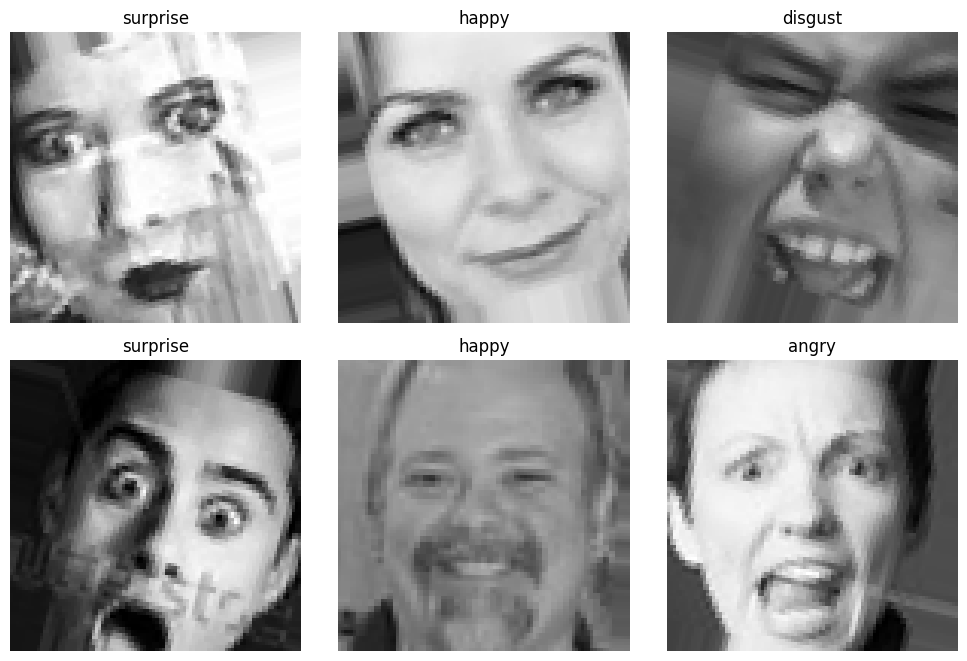

In [34]:
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(10,10))

for i in range(6):
    plt.subplot(3,3,i+1)

    img = images[i]  # Extract single image
    if img.shape[-1] == 1:  # Grayscale image
        plt.imshow(img.squeeze(), cmap="gray")
    else:  # RGB image
        plt.imshow(img)

    plt.title(class_names[np.argmax(labels[i])])  # Get class label
    plt.axis("off")

plt.tight_layout()
plt.show()

In [35]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 46s 5us/step


In [36]:
# Freeze base model
base_model.trainable = False


In [37]:
# Add custom classifier layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

In [38]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


In [ ]:
# Train the model
model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/30


C:\Users\Asit\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 61/901 ━━━━━━━━━━━━━━━━━━━━ 3:04 219ms/step - accuracy: 0.2057 - loss: 2.1969